In [3]:
!python detect.py --weights yolov7.pt --conf 0.25 --img-size 640 --source inference/images/horses.jpg --save-txt

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=True, source='inference/images/horses.jpg', update=False, view_img=False, weights=['yolov7.pt'])
YOLOR 🚀 v0.1-36-g2267955 torch 1.8.1 CPU

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
Model Summary: 306 layers, 36905341 parameters, 6652669 gradients
 Convert model to Traced-model... 
[2022-07-21 15:37:06.617 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:88 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-07-21 15:37:06.798 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:88 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
 traced_script_module saved! 
 model is traced! 

torch.Size([1, 3, 448, 640])
---------
te

In [5]:
import argparse
import time
from pathlib import Path

import cv2
import torch
import torch.backends.cudnn as cudnn
from numpy import random

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized, TracedModel

In [6]:
model = attempt_load('yolov7.pt',map_location='cpu')

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block


In [7]:
source='inference/images/horses.jpg'
imgsz=640
stride = int(model.stride.max())
imgsz = check_img_size(imgsz, s=stride) 
dataset = LoadImages(source, img_size=imgsz, stride=stride)
for path, img, im0s, vid_cap  in dataset:
    pass

In [8]:
names = model.module.names if hasattr(model, 'module') else model.names

In [9]:
import matplotlib.pyplot as plt
import numpy as np

(3, 448, 640)


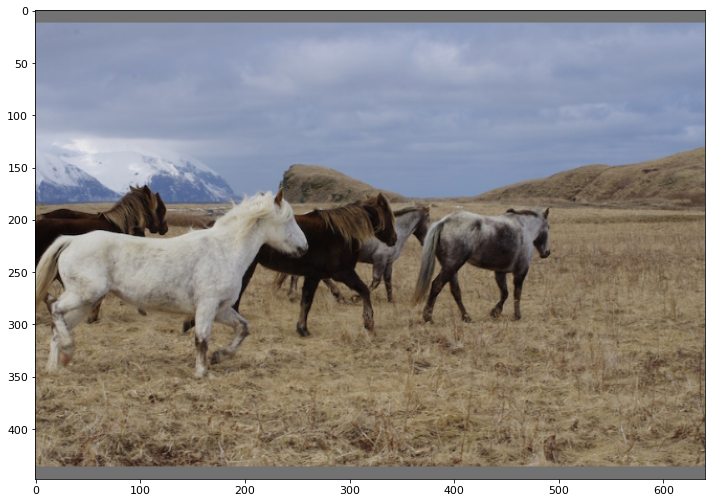

In [10]:
print(img.shape)
plt.figure(figsize=(12,12))
plt.imshow(np.moveaxis(img,[0,1,2],[2,0,1]).copy())
plt.show()

In [11]:
device='cpu'
img = torch.from_numpy(img).to(device).float()

In [12]:
img /= 255.0

In [13]:
if img.ndimension() == 3:
    img = img.unsqueeze(0)

In [14]:
pred = model(img, augment=None)[0]

[2022-07-21 07:59:30.039 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:114 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-07-21 07:59:30.250 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:114 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


In [15]:
print(pred.shape)
print(img.shape)
print(len(names))

torch.Size([1, 17640, 85])
torch.Size([1, 3, 448, 640])
80


In [16]:
pred2 = non_max_suppression(pred, 0.25, 0.45, classes=None, agnostic=None)

In [17]:
print(pred2)
print(names[17])

[tensor([[ 2.34680e-02,  1.70267e+02,  2.60834e+02,  3.52550e+02,  9.57346e-01,  1.70000e+01],
        [ 3.58191e+02,  1.88144e+02,  4.92526e+02,  2.99508e+02,  9.43669e-01,  1.70000e+01],
        [-2.95296e-02,  1.66295e+02,  1.27356e+02,  2.49706e+02,  8.59475e-01,  1.70000e+01],
        [ 1.86901e+02,  1.74327e+02,  3.47514e+02,  3.13525e+02,  8.03257e-01,  1.70000e+01],
        [ 3.06441e+02,  1.85712e+02,  3.77829e+02,  2.78751e+02,  6.91403e-01,  1.70000e+01]], grad_fn=<IndexBackward>)]
horse


In [18]:
!cat runs/detect/exp7/labels/horses.txt


17 0.534282 0.519531 0.111255 0.21875
17 0.417853 0.546875 0.25097 0.328125
17 0.0996119 0.461914 0.199224 0.197266
17 0.664942 0.546875 0.209573 0.261719
17 0.203752 0.587891 0.407503 0.429688


In [21]:
input_np = np.zeros((1,3,640,640),dtype='float32')
img = torch.from_numpy(input_np).to(device).float()
aux = model(img, augment=None)[0]
print(aux.shape)

torch.Size([1, 25200, 85])


In [22]:
ts = torch.jit.trace(model, img, strict=False)
ts.save('test.torchscript.pt')

/root/test/padel_ia/yolov7/models/yolo.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.grid[i].shape[2:4] != x[i].shape[2:4]:


In [23]:
import onnx
torch.onnx.export(model, img, 'testonnx.onnx', verbose=False, opset_version=12, input_names=['images'],
                          output_names=['output'],
                          dynamic_axes={'images': {0: 'batch', 2: 'height', 3: 'width'},  # size(1,3,640,640)
                                        'output': {0: 'batch', 2: 'y', 3: 'x'}} )


ModuleNotFoundError: No module named 'onnx'

In [1]:
%conda install onnx

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: - 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
                                                                               failed

UnsatisfiableError: The following specifications were found
to be incompatible with the existing python installation in your environment:

Specifications:

  - onnx -> python[version='>=3.7,<3.8.0a0|>=3.8,<3.9.0a0|>=3.9,<3.10.0a0']

Your python: python=3.6.13

If python is on the left-most side of the chain, that's the version you've asked for.
When python appears to the right, that indicates that the thing on the left is somehow
not available for the python version you are constrained to. Note that

In [ ]:
def letterbox(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)


In [ ]:
# Compute conf
x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf
# Box (center x, center y, width, height) to (x1, y1, x2, y2)
box = xywh2xyxy(x[:, :4])



# im0 is the original image
# img is the letterboxed image with channels in the first axis
#for *xyxy, conf, cls in reversed(det):



gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh

plot_one_box(xyxy, im0, label=label, color=colors[int(cls)], line_thickness=3)
det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()